# SLU7 - Regression with Linear Regression: Learning notebook

In this notebook we will cover the following:
    - What is regression?
    - Simple Linear Regression
    - Mean Squared Error
    - Closed Form Solution - Ordinary Least Squares
    - Multiple Linear Regression
    - Scikit LinearRegression
    - Gradient Descent basics

## What is regression? 

A modeling task which objective is to create a (linear or non-linear) map between the **independent variables** (i.e. the columns in your pandas dataframe) and a set of **continuous dependent variables** (i.e. the variable you want to predict) by estimating a set of **parameters**. 

**Examples of regression tasks:**

* predicting house prices (example range: \[ 100k €; 500k € \]);
* predicting the rating that a user would assign to a movie (example range: [1 start; 7 stars]); 
* predicting the total sales for each day, in each shop of a shopping mall;
* predicting emotional descriptors for a song;
* predicting the trajectory of a fighter jet.

**Predicting house prices:**

Let's align the first 3 terms we used with an example: 

When predicting house prices...

* the **independent variables** are the features related to the house like the number of rooms, the total area available, the crime rate of the neighborhood, the number of miles to the closest big city; 
* the **dependent variable** is the price of the house;
* the **parameters** are a set of internal variables that will define the mapping between the previous variables.

To predict the house prices, the regression model will take the independent variables and its internal parameters, perform a sequence of operations with those two and output the price of the house.

Nowadays, there are *a lot* of algorithms to solve this task but we will focus on one of the easiest to understand: **linear regression**. It is one of the most used regression methods in the world to this day due to how easy it is to (1) interpret the model, (2) implement it and (3) implement extensions that deal with datasets with few data points, noise, and outliers. 

First, let's explore how **simple linear regression** works.

# 1 - Simple Linear Regression

This model is a special case of linear regression where you have a single feature. The model is, simply, a line equation

$$\hat{y} = \beta_0 + \beta_1 \cdot x$$

* $\hat{y}$ is the value predicted by the model; 
* $x$ is the input feature; 
* $\beta_0$ is the y-axis value where $x=0$, usually called the *intercept*; 
* $\beta_1$ tells you how much $\hat{y}$ changes when $x$ changes, usually called the *coefficient*.

The impact of $x$ in $\hat{y}$ can be state as the following: _For each unit you increment in $x$, you increment $\beta_1$ units in $\hat{y}$._


#### House pricing example:

For example: 

$$HousePrice = 1.1 + 4 \cdot NumberOfRooms$$

means that the _price of the house increments 4 units (e.g. 1 unit = 10000€) each time I add a room to the house._

## 1.1 - Implementing and visualizing a simple linear model

You can create a simple lambda function in order to implement this model:

In [1]:
linear_regression = lambda x, b0, b1: b0 + b1 * x

And then use it by passing some data and parameters:

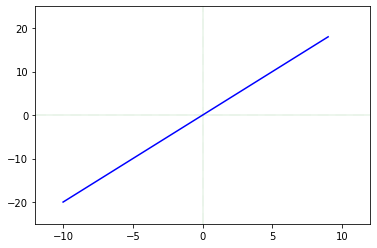

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def plot_regression_simple(x, y, xlim, ylim):
    origin = (0, 0)

    # Set the x-axis and y-axis limits for the axes
    plt.xlim(xlim)
    plt.ylim(ylim)

    # Plot axis for better visualization
    plt.plot(origin, ylim, 'g:', xlim, origin, 'g:', linewidth=0.4)

    # Plot linear model
    plt.plot(x, y, 'b')
    plt.show()

# Base independent data
x_lin = np.arange(-10, 10)

# Parameters
intercept = 0
coefficient = 2

# Dependent variable
y_lin = linear_regression(x_lin, intercept, coefficient)
plot_regression_simple(x_lin, y_lin, (-12, 12), (-25, 25))

Now, imagine that we have some data with noise that we want to fit. Let's load it and visualize its shape:

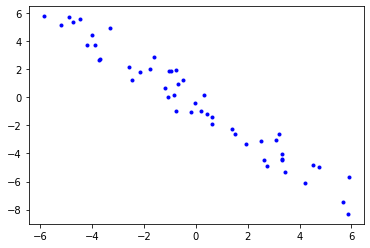

In [3]:
import pandas as pd 

df = pd.read_csv('data/linear-learning-notebook.csv')
df = df.sort_values('x')
x_lin_df = df['x'].values
y_lin_df = df['y'].values

plt.plot(x_lin_df, y_lin_df, 'b.')

Clearly the data looks linear, and you can easily see how good a model fits just by looking at it, right?

Use the interactive demo to try it out below:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider, Dropdown
import ipywidgets as widgets

def plot_simple_regression(b0=0, b1=1, xlim=(-5, 5), ylim=(-5, 5)):
    y_pred = linear_regression(x_lin_df, b0, b1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(x_lin_df, y_lin_df, 'b.')
    plt.plot(x_lin_df, y_pred, 'r-')
    plt.plot([0, 0], ylim, 'g-', xlim, [0, 0], 'g-', linewidth=0.4)


def simple_linear_regression_manual_demo_1(): 
    interact(plot_simple_regression, 
         b0=FloatSlider(min=-10, max=10, step=0.01, value=0), 
         b1=FloatSlider(min=-3, max=3, step=0.01, value=1), 
         xlim=fixed((-10, 10)), 
         ylim=fixed((-10, 10)));

simple_linear_regression_manual_demo_1()

interactive(children=(FloatSlider(value=0.0, description='b0', max=10.0, min=-10.0, step=0.01), FloatSlider(va…

The green plot represents both the x and y-axes while the red line is the $\hat{y}$ for each value of $x$. As you can see for yourself, if you decrease/increase $\beta_0$, the value where y cross $\hat{y}$ decreases/increases. If you increase/decrease $\beta_1$, the slope of the line increases/decreases.

If you were at all familiar with simple linear models before, this should all looking too easy for you. 

![easy](assets/easy_peasy.gif)

However, you might also notice that, although you can get a somewhat good solution, you have no way of knowing exactly how good this solution is. Slight variations around your solution might seem just as adequate just by looking at the plot. 

So at this point, you might be thinking, there's gotta be a better way.

## 1.2 - Error measure for Linear Regression

Here is where error measures come in. By finding a way of measuring the error in our models, we can more easily find a model that produces the least error. So let's dive into that.

The main goal of modeling the data is getting our estimates to be as close to the labels as possible. So, if for each sample, my model outputs a value $\hat{y_i}$ and we know its true label is $y_i$, then a direct definition of how much the model is wrong would follow:

$$ e_i = y - \hat{y_i} $$

But this would only consider one sample, and as we know, the observations might contain noise. So we need to consider all of our observations together and their aggregated error. There are actually several ways of doing this, but the error we will present here is called Mean Squared Error - a standard metric used for linear regressions.

$$MSE(y, \hat{y}) = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 $$

where, as stated above, $\hat{y}$ is just the output of our linear model:

$$\hat{y} = \beta_0 + \beta_1 \cdot x$$

This is what we usually call a **cost function** or **error function**, representing the error between the true label of our samples and the predictions of our model. The better our model is , the lower this metric should be. We normally use the notation $J$ to refer to the cost function:

$$J(y, \hat{y}) = MSE = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 $$


We can implement this metric with a lambda function also:

In [5]:
linear_regression_mse = lambda y, y_hat: ((y - y_hat)**2).mean()

See how the metric increases when our inputs are further apart and decreases when they are close together. In particular, if the prediction matches the label, then the metric is just zero.

In [6]:
labels = np.array([0.2, 0.45])
close_estimates = np.array([0.25, 0.5])
far_estimates = np.array([10., 10.])

print('Small error measure for close inputs: {}'.format(linear_regression_mse(labels, close_estimates)))
print('Big error measure for distant inputs: {}'.format(linear_regression_mse(labels, far_estimates)))
print('Null error measure for equal inputs: {}'.format(linear_regression_mse(labels, labels)))

Small error measure for close inputs: 0.0024999999999999988
Big error measure for distant inputs: 93.62125000000002
Null error measure for equal inputs: 0.0


At this point, it should make sense to you that decreasing this metric will lead to a better model. 


Try to use this metric in the following demo, to find the linear model that fits our data the best, and notice that it goes up as you change towards a worse model, and down as you slide towards a better model.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider, Dropdown
import ipywidgets as widgets

def plot_regression(b0=0, b1=1, xlim=(-5, 5), ylim=(-5, 5)):
    y_pred = linear_regression(x_lin_df, b0, b1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(x_lin_df, y_lin_df, 'b.')
    plt.plot(x_lin_df, y_pred, 'r-')
    plt.plot([0, 0], ylim, 'g-', xlim, [0, 0], 'g-', linewidth=0.4)
    return "Mean Squared Error (MSE): {}".format(linear_regression_mse(y_lin_df, y_pred))


def simple_linear_regression_manual_demo_2(): 
    interact(plot_regression, 
         b0=FloatSlider(min=-10, max=10, step=0.01, value=0), 
         b1=FloatSlider(min=-3, max=3, step=0.01, value=1), 
         xlim=fixed((-10, 10)), 
         ylim=fixed((-10, 10)));

simple_linear_regression_manual_demo_2()

interactive(children=(FloatSlider(value=0.0, description='b0', max=10.0, min=-10.0, step=0.01), FloatSlider(va…

So by now you should be convinced that the metric we gave you works.

But ok, doing this manually sucks. So, humans developed optimization algorithms to allow machines to adjust $\beta_0$ and $\beta_1$ according to some dataset. There are a few ways of doing this:

1. Closed form solution through normal equations;
2. Iterative methods using gradients;
3. Evolutionary methods like genetic algorithms or particle swarm; 
4. Bayesian optimization.

We will explore the first method here, since it is the standard form of solving simple regression problems, and will introduce the gradient descent method also. Gradient descent methods are quite usefull because they provide a, somehow, universal approach to optimization tasks and are really simple to grasp. Although we will use a simple version in this Learning Unit,  you will learn more about it on the next SLU for classification.

## 1.3 -  Closed form solution of Simple Linear Regression models


In any optimization problem, our goal is to minimize the error. This is, if our error function has a global minima with respect to the parameters of the model, those are the parameters we want to find. Take the plot below:

![cost-function-decrease](assets/cost-function-decrease.jpg)

Assuming our function is convex, the problem of getting the minimum can be solved by looking for the point where the derivative is zero. This is exactly what we will do in both the closed form solution and in iterative methods. So, depending on our error function we use, we need to find ways of derivating with respect to each weight in our equations. 

This sounds like a lot. So if you are not familiar with these concepts at all, you might start to despair.

![cost-function-decrease](assets/derivative-panic.gif)


But don't worry, we know this is a bootcamp, we're not gonna ask you to learn derivatives over the night. In the same way we provide you with the error measure, we'll also give you the derivatives with respect to the weights.

### 1.3.1 - Derivative of error function

The derivatives of the error function with respect to our weights are actually very simple expressions. If you are interested in how to get there, you can take a look at the deduction in [this notebook](bonus/Derivatives%20and%20closed%20form%20for%20simple%20linear%20model.ipynb). But for now, just know that we are not tricking you:


First we have the derivative of the intercept:

$$\frac{d J}{d \beta_0} = -\frac{1}{N} \sum_{i=1}^N [2 (y_i - \hat{y_i})] $$

And then the derivative of the coefficient:

$$ \frac{d J}{d \beta_1} = -\frac{1}{N}\sum_{i=1}^N [2( y_i - \hat{y_i})x_i] $$

We could also easily implement them as lambda functions

In [8]:
mse_derivative_b0 = lambda y, y_hat: (2*(y - y_hat)).mean()
mse_derivative_b1 = lambda y, y_hat, x: (2*(y - y_hat)*x).mean()

### 1.3.2 - Closed Form Solution

Let's move on to the final part. After all, the goal of all these equations is just to get a solution for our model, right? 

As we explained before, the closed form solution comes from looking for the point where the derivatives are zero. Once again, we will only show you the final result of doing that, but please look to [this notebook](bonus/Derivatives%20and%20closed%20form%20for%20simple%20linear%20model.ipynb) if you want to see how to get there, step by step. The solution for the simple linear regression is then:

$$ \frac{d J}{d \beta_0} = 0 \rightarrow \beta_0 = \bar{y} - \beta_1 \bar{x} $$ 

$$ \frac{d J}{d \beta_1} = 0 \rightarrow  \beta_1 = \frac{\sum_{i}^{N}{(x_i - \bar{x})(y_i - \bar{y})}}{\sum_{i}^{N}{(x_i - \bar{x})^2}} = \frac{cov(x, y)}{var(x)}$$

with cov(x,y) and var(x) are, respectively, the covariance and variance of the samples and $\bar{y} = \frac{1}{N}\sum_{i}^{N}{y_i}$ and $\bar{x} = \frac{1}{N}\sum_{i}^{N}{x_i}$ are the means of the sample.

Let's try it out for our previous problem:

In [9]:
import pandas as pd 

df = pd.read_csv('data/linear-learning-notebook.csv')
df = df.sort_values('x')
x_lin_df = df['x'].values
y_lin_df = df['y'].values

Let's first compute the means of our sample:

In [10]:
x_mean = x_lin_df.mean()
y_mean = y_lin_df.mean()

Now we can compute the coefficient:

In [11]:
top = np.sum((x_lin_df - x_mean)*(y_lin_df - y_mean))
bottom = np.sum((x_lin_df - x_mean)**2)
beta_1 = top/bottom

print('Coefficient: {}'.format(beta_1))

Coefficient: -1.144592552399212


And then we compute the intercept:

In [12]:
beta_0 = y_mean - beta_1 * x_mean

print('Intercept: {}'.format(beta_0))

Intercept: -0.4517184116834487


Plot below the data and the solution found, together with the error measure:

Mean Squared Error (MSE): 0.7232679595171865


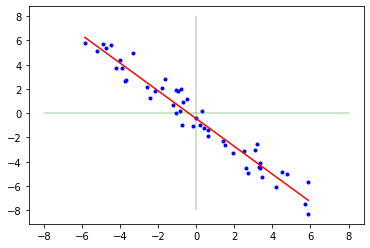

In [13]:
import matplotlib.pyplot as plt

y_pred = linear_regression(x_lin_df, beta_0, beta_1)
plt.plot(x_lin_df, y_lin_df, 'b.')
plt.plot(x_lin_df, y_pred, 'r-')
plt.plot([0, 0], [-8, 8], 'g-', [-8, 8], [0, 0], 'g-', linewidth=0.4)

print("Mean Squared Error (MSE): {}".format(linear_regression_mse(y_lin_df, y_pred)))

And that's it, we've implemented a closed form of solving the simple linear regression. This form can be extended for the multiple linear regression problem you are going to see below. It is also known as **Ordinary Least Squares**, since it minimizes the squared error, and it is actually what is implemented (with a bit more detail) inside scikitlearn. 

# 2 - Multiple Linear Regression

The simple linear regression is a good example to get you started, but most phenomena in our world is dependent on several factors. For example, house prices depend on things like (1) number of rooms, (2) distance to malls, (3) distance to parks, (4) how old the house is, etc. As such, it would be naive, at best, to create a univariate linear model to predict the house prices. So, let's expand our simple linear regression into *multiple* linear regression:

$$\hat{y} = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + \beta_3 \cdot x_3 + \beta_4 \cdot x_4 + \beta_5 \cdot x_5$$ 

This can also be written in a collapsed form:

$$\hat{y} = \beta_0 + \sum_{i=1}^{5} \beta_i \cdot x_i$$

And the model generalizes to the following:

$$\hat{y} = \beta_0 + \sum_{i=1}^{N} \beta_i \cdot x_i$$

with an arbitrary number of weights, which correspond to the input features. We can also write it as the combination of matrices:

$$\hat{y} = \beta_0 + X\vec{\beta} $$

Where $X$ is a matrix with shape (num_samples, num_features) and $\vec{\beta}$ the vector of coefficients. 



## 2.1 - Implementing and visualizing a multiple linear model


This is still a simple model, and we can implement it with a lambda function again.

In [14]:
multiple_linear_regression = lambda x, betas: betas[0] + np.matmul(x, betas[1:])

Multiple linear regressions are a not as easy to visualize, since they have multiple inputs that affect the output, which, instead of a line, results in a **hyperplane**. However, there is a particular case that we can model and visualize quite easily - the polynomial regression.

Polynomial functions are defined as follows:

$$\hat{y} = \beta_0 + \beta_1 x +  \beta_2 x^2 + ... +  \beta_n x^n $$

where $n$ is the order of our polynomial function.

You might be wondering how we can model these functions, which are clearly not linear, with a linear model. The main thing you need to understand is that, even though the inputs are not linear, the model is linear with respect to the coefficients, this is, we can easily assume each power of $x$ as a different input:

$$ x = x_1 $$
$$ x^2 = x_2 $$
$$...$$
$$ x^n = x_n $$

And have the same model from above

$$\hat{y} = \beta_0 + \sum_{i=1}^{N} \beta_i \cdot x_i$$

Run the next cell to see how a polynomial model can be represented as a multiple linear model:


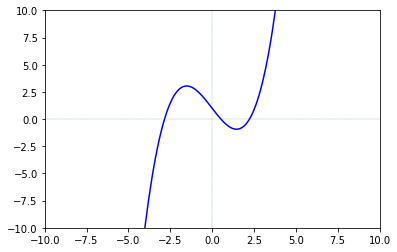

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_polynomial_regression_multiple(x, y, xlim, ylim):
    origin = (0, 0)

    plt.xlim(xlim)
    plt.ylim(ylim)

    # Plot axis for better visuzlization
    plt.plot(origin, ylim, 'g:', xlim, origin, 'g:', linewidth=0.4)

    # Plot linear model
    plt.plot(x, y, 'b')
    plt.show()

# Base independent variables
x_pln = np.arange(-10, 10, 0.1).reshape(-1, 1)
x_pln_2 = x_pln ** 2
x_pln_3 = x_pln ** 3

# Organize input in a matrix
X_pln = np.concatenate((x_pln, x_pln_2, x_pln_3), axis=1)

# Parameters
betas_pln = [1, -2, .025, .3]

# Dependent variable
y_pln = multiple_linear_regression(X_pln, np.array(betas_pln))
plot_regression_simple(x_pln.flatten(), y_pln, [-10, 10], [-10, 10])

Now, let's follow the same procedure we followed for the simple model and imagine that we have some data with noise that we want to fit. Let's load it and visualize its shape:

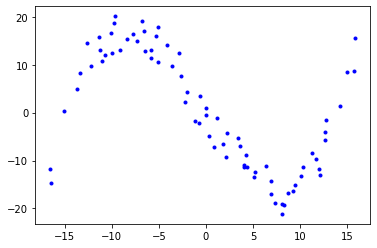

In [16]:
df = pd.read_csv('data/polynomial-learning-notebook.csv')
df = df.sort_values('x')

x_pln_df = df['x'].values
y_pln_df = df['y'].values
X_pln_df = df.drop(columns='y').values

plt.plot(x_pln_df, y_pln_df, 'b.')

Try to do the same as before , and find the weights manually:

In [17]:
def plot_polynomial_regression(b0=0, b1=1, b2=0, b3=0, xlim=(-20, 20), ylim=(-20, 20)):
    betas = np.array([b0, b1, b2, b3])
    y_pred = multiple_linear_regression(X_pln_df, betas)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(x_pln_df, y_pln_df, 'b.')
    plt.plot(x_pln_df, y_pred, 'r-')
    plt.plot([0, 0], ylim, 'g-', xlim, [0, 0], 'g-', linewidth=0.4)

def polynomial_regression_manual_demo_1(): 
    interact(plot_polynomial_regression, 
         b0=FloatSlider(min=-10, max=10, step=0.01, value=0), 
         b1=FloatSlider(min=-5, max=5, step=0.01, value=1), 
         b2=FloatSlider(min=-1, max=1, step=0.01, value=0), 
         b3=FloatSlider(min=-1, max=1, step=0.01, value=0), 
         xlim=fixed((-20, 20)), 
         ylim=fixed((-20, 20)));

polynomial_regression_manual_demo_1()

interactive(children=(FloatSlider(value=0.0, description='b0', max=10.0, min=-10.0, step=0.01), FloatSlider(va…

As you can see, it is much harder now to find these features manually. Let's see if having an error measure this time helps at all:

## 2.2 - Error measure for Multiple Linear Regression

Using the same logic as before, we still want a way to measure how well our model fits. Notice that, even though our model has several inputs and corresponding increase in parameters, it still produces a single output. 

This means that we can still define the error as

$$ e_i = y - \hat{y_i} $$

So we will use the same cost function as before:

$$MSE(y, \hat{y}) = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 $$

The only different being how the estimate $\hat{y}$ is produced. Use it in the interactive demo as before:

In [18]:
def plot_polynomial_regression(b0=0, b1=1, b2=0, b3=0, xlim=(-20, 20), ylim=(-20, 20)):
    betas = np.array([b0, b1, b2, b3])
    y_pred = multiple_linear_regression(X_pln_df, betas)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(x_pln_df, y_pln_df, 'b.')
    plt.plot(x_pln_df, y_pred, 'r-')
    plt.plot([0, 0], ylim, 'g-', xlim, [0, 0], 'g-', linewidth=0.4)
    return "Mean Squared Error (MSE): {}".format(linear_regression_mse(y_pln_df, y_pred))

def polynomial_regression_manual_demo_1(): 
    interact(plot_polynomial_regression, 
         b0=FloatSlider(min=-10, max=10, step=0.01, value=0), 
         b1=FloatSlider(min=-5, max=5, step=0.01, value=1), 
         b2=FloatSlider(min=-1, max=1, step=0.01, value=0), 
         b3=FloatSlider(min=-0.5, max=0.5, step=0.005, value=0), 
         xlim=fixed((-20, 20)), 
         ylim=fixed((-20, 20)));

polynomial_regression_manual_demo_1()

interactive(children=(FloatSlider(value=0.0, description='b0', max=10.0, min=-10.0, step=0.01), FloatSlider(va…

It is still very hard to have to handle so many levers. So for the multiple linear regression, automatic methods are even more important. We'll follow with an extension of the closed form solution.

## 2.3 - Closed form solution of Multiple Linear Regression models

### 2.3.1 - Derivative of error function

The derivatives of the error function with respect to our weights are very similar to the ones in the simple scenario. We built another notebook so you can see how to deduct them, so consult [this notebook](bonus/Derivatives%20and%20closed%20form%20for%20multiple%20linear%20model.ipynb) if you are interested in that. 

The derivative of the intercept remains the same:

$$\frac{d J}{d \beta_0} = -\frac{1}{N} \sum_{i=1}^N [2 (y_i - \hat{y_i})] $$

Then, for the coefficients, the expression is still very similar to the one before. The only detail you need to pay attention to, is that the input multiplied in the derivative is just the one corresponding to the feature that the weight refers to:

$$ \frac{d J}{d \beta_k} = -\frac{1}{N}\sum_{i=1}^N [2( y_i - \hat{y_i})x_{k_i}] $$ 

for $ k \in [1, K] $ , where K is the number of features of our model.

Once again, we can implement them as lambda functions.

In [19]:
mse_derivative_b0 = lambda y, y_hat: -(2*(y - y_hat)).mean()
mse_derivative_bk = lambda y, y_hat, x_k: -(2*(y - y_hat)*x_k).mean()

### 2.3.2 - Closed Form Solution

For this closed form solution, it is usefull to make use of matrix notation. We can take our initial model, defined above:

$$\hat{y} = \beta_0 + X\boldsymbol{\beta} $$

Or even go a step further an write:

$$\hat{y} = X' \vec{\beta}$$

If we consider a new matrix $X'$ of inputs which is simply the concatenation of a column of ones to our previous inputs matrix:

$$ X' = [\vec{1} | X]$$

Once again, the closed form solution comes from looking for the point where the derivatives are zero but we will only show you the final result of doing that. Look to [this notebook](bonus/Derivatives%20and%20closed%20form%20for%20simple%20linear%20model.ipynb) if you want to see how to get there, step by step. The solution for the multiple linear regression is then:

$$ \vec{\beta} = (X^TX)^{-1}(X^T\vec{y})$$


Where $X$ is our matrix of samples extended to add a 1 component in each sample, $X = [\vec{1} | X] $ , $\vec{y}$ is the output vector, and $\vec{\beta}$ the weight vector with weights $\beta_0$ and $\beta_1$

Try it out for the previous example. Let's load the data again:

In [20]:
df = pd.read_csv('data/polynomial-learning-notebook.csv')
df = df.sort_values('x')

x_pln_df = df['x'].values
y_pln_df = df['y'].values
X_pln_df = df.drop(columns='y').values

First let's extend our inputs to have a column of ones: 

$$ X' = [\vec{1} | X] $$

In [21]:
X_extended = np.concatenate((np.ones((X_pln_df.shape[0], 1)), X_pln_df), axis=1)

Now let's apply the closed form solution:

In [22]:
inv_xx = np.linalg.inv(np.matmul(X_extended.T, X_extended))
xy = np.matmul(X_extended.T, y_pln_df)
betas = np.matmul(inv_xx, xy)

print('Coefficients: {}'.format(betas))

Coefficients: [-0.58366246 -2.95329261  0.01443483  0.01440652]


Finally let's plot the solution we achieved and the error associated:

Mean Squared Error (MSE): 7.293313137336586


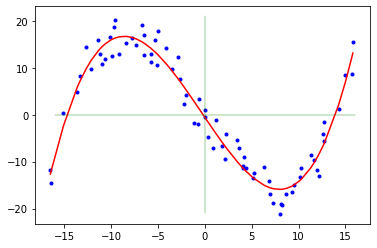

In [23]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = multiple_linear_regression(X_pln_df, betas)
plt.plot(x_pln_df, y_pln_df, 'b.')
plt.plot(x_pln_df, y_pred, 'r-')
plt.plot([0, 0], [-21, 21], 'g-', [-16, 16], [0, 0], 'g-', linewidth=0.4)

print("Mean Squared Error (MSE): {}".format(linear_regression_mse(y_pln_df, y_pred)))

We'll do an extra example, with a diabetes dataset. This contains several features of individuals and a quantitative measure of disease progression. Load the diabetes dataset below, read its description and look into the data.

In [24]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes

data = load_diabetes()
print(data['DESCR'])

X_db = pd.DataFrame(data['data'], columns=data['feature_names'])
y_db = pd.Series(data['target'], name='medv')

pd.concat((X_db, y_db), axis=1).head(5)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,medv
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Let's apply our closed form solution and see what output and error we get:

In [25]:
X_extended = np.concatenate((np.ones((X_db.values.shape[0], 1)), X_db.values), axis=1)

inv_xx = np.linalg.inv(np.matmul(X_extended.T, X_extended))
xy = np.matmul(X_extended.T, y_db.values)
betas = np.matmul(inv_xx, xy)

y_pred = multiple_linear_regression(X_db.values, betas)

print('Feature coefficients: ')
print(pd.Series(betas[1:], X_db.columns))
print('\n')

print('Intercept: {}'.format(betas[0]))
print('\n')

print('\nTargets for the first 5 rows: \n\n', y_db.head(5).values)
print('\nPredictions for the first 5 rows: \n\n', y_pred[:5])
print("Mean Squared Error (MSE): {}".format(linear_regression_mse(y_db.values, y_pred)))

Feature coefficients: 
age    -10.012198
sex   -239.819089
bmi    519.839787
bp     324.390428
s1    -792.184162
s2     476.745838
s3     101.044570
s4     177.064176
s5     751.279321
s6      67.625386
dtype: float64


Intercept: 152.13348416289648



Targets for the first 5 rows: 

 [151.  75. 141. 206. 135.]

Predictions for the first 5 rows: 

 [206.11706979  68.07234761 176.88406035 166.91796559 128.45984241]
Mean Squared Error (MSE): 2859.6903987680657


Pretty simple, hein? The extended model is just an extension of the simple one. The more features you have, the more you include in the sum! And we still have a simple closed form solution!

But there is a **very important assumption** that this model does: there is no multicollinearity in your data. 
 <em>What the hell does that even mean?</em>, you might ask. This term comes from linear algebra and this is what it means: 

_If you have a feature $x_i$ which the values can be obtained through a **linear combination** of other features, then we have multicollinearity._

Let me give you some of the reasons this is a problem: 
1. When people use linear regressions, after the parameter estimation phase, they use the coefficients as a way to measure **how important a feature is**. When you use collinear features, the magnitude of the weights gets's lowered for all features that are in that collinear relationship. That might be misleading because collinear features are, essentially, one feature.
2. Collinear features add no value to the model, it is like cloning the same feature and concatenating it to the dataset. 

# 3 - Linear Regression with Scikitlearn

After learning the basics of linear regression and how to implement the closed form solutions, it is time to learn how to use linear regression with Scikit Learn. 

[Scikit Learn][sklearn] is an industry standard for data science and machine learning and we will be using it extensively throughout the academy. Scikit Learn has several implementations of linear regression:
* [*sklearn.linear_model.LinearRegression*][LinearRegression]: uses normal equations to estimate the best intercept and coefficients. Normal equations are the closed form solution for linear regression, meaning that you know exactly the number of steps and the guarantees about the solution. If you want to know more about this, [read this blog post][normal_eq].
* [*sklearn.linear_model.SGDRegressor*][SGDRegressor]: SGD Regressor is a model that is optimized (trained) using SGD (Stochastic Gradient Descent) for regression tasks. It's basically a linear model that is updated along the way with a decaying learning rate. (go to [Section 4](#grad_desc) to learn more about it)

[SGDRegressor]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor
[LinearRegression]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression
[sklearn]: http://scikit-learn.org
[normal_eq]: https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression

For simplicity and because you're new to this world, let's try by implementing the first one *LinearRegression*.

Let's start by applying this to the polynomial example from the previous examples:

In [26]:
df = pd.read_csv('data/polynomial-learning-notebook.csv')
df = df.sort_values('x')

x_pln_df = df['x'].values
y_pln_df = df['y'].values
X_pln_df  = df.drop(columns='y').values

Now, let's use the LinearRegression from scikitlearn:

In [27]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_pln_df, y_pln_df)
coefficients = lr.coef_
intercept = lr.intercept_
betas = np.concatenate((np.array([intercept]), coefficients))

Now let's plot the solution as we did before:

Mean Squared Error (MSE): 7.293313137336584


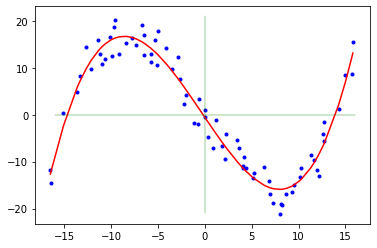

In [28]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = multiple_linear_regression(X_pln_df, betas)
plt.plot(x_pln_df, y_pln_df, 'b.')
plt.plot(x_pln_df, y_pred, 'r-')
plt.plot([0, 0], [-21, 21], 'g-', [-16, 16], [0, 0], 'g-', linewidth=0.4)

print("Mean Squared Error (MSE): {}".format(linear_regression_mse(y_pln_df, y_pred)))

Now let's do the same for the diabetes example:

In [29]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes

data = load_diabetes()

X_db = pd.DataFrame(data['data'], columns=data['feature_names'])
y_db = pd.Series(data['target'], name='medv')

pd.concat((X_db, y_db), axis=1).head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,medv
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Let's experiment with the first linear regression implementation:

In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_db, y_db)
coefficients = lr.coef_
intercept = lr.intercept_

print('Feature coefficients: ')
print(pd.Series(coefficients, X_db.columns))
print('\n')

print('Intercept: {}'.format(intercept))
print('\n')

print('\nTargets for the first 5 rows: \n\n', y_db.head(5).values)
print('\nPredictions for the first 5 rows: \n\n', lr.predict(X_db.head(5)))
print("Mean Squared Error (MSE): {}".format(linear_regression_mse(y_db.values, lr.predict(X_db))))

Feature coefficients: 
age    -10.012198
sex   -239.819089
bmi    519.839787
bp     324.390428
s1    -792.184162
s2     476.745838
s3     101.044570
s4     177.064176
s5     751.279321
s6      67.625386
dtype: float64


Intercept: 152.1334841628965



Targets for the first 5 rows: 

 [151.  75. 141. 206. 135.]

Predictions for the first 5 rows: 

 [206.11706979  68.07234761 176.88406035 166.91796559 128.45984241]
Mean Squared Error (MSE): 2859.6903987680657


### Note: normalization

In our example, notice that this dataset is already normalized (run cell below):

In [31]:
X_db.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


This is not always the case, so you should always check if your dataset is normalized, and, if not, you should always normalize your dataset into a unified scale (e.g. range [0; 1]). The reasons why:

1. Depending on what optimization algorithm you use, if feature $f_1$ has a domain of [-4.1; 3] and feature $f_2$ has a domain of [-1.1; 100000], the impact in the gradient can lead to problems in the convergence to the global minima (i.e. you probably won't get accurate results for your predictions). There are optimization algorithms that can avoid this issue but still suffer from the issue (2).
2. If two features are using different ranges, it will be hard to compare features in terms of feature importance. If a feature ($f_1$) has a domain of [-0.1; 0.1] and another ($f_2$) has domain of [0; 1000], it doesn't make sense to look at the influence in the prediction through the same lens as the ones we use in the introduction to simple linear regression (i.e. an increase of 1 unit in $x$ increases $\beta_1$ units in $\hat{y}$). Due to the fact that feature $f_1$ never goes to -1 or +1, that interpretation wouldn't make sense and, as such, we would have two options:
    1. normalize the resulting coefficients accordingly to the scale;
    2. or normalize the inputs into the same scale.
    


### Summary: Linear Regression Pros & Cons

**PROS**
* Really easy to understand
* Fast optimization
* Easy to extend the model: you haven't seen how this is true but there is a thing called _Generalized Linear Model (GLM)_. Once you get a good grip on linear regression, you should visit the [scikit learn page on GLMs](http://scikit-learn.org/stable/modules/linear_model.html).

**CONS**
* Sensible to outliers, even though there are extensions that are able to deal (partially) with this issue.
* Assumes that there is no multicollinearity.
* Feature scaling is required.
* Monotonicity assumption: for the model, the relation between each feature and the output. 
* Categorical encoding: this might get tricky when the number of uniques is big and part of those uniques have few occurrences.


#### Notes

At this point, if you already knew linear regression in detail before the academy, you might be wondering: <em>"Where is the error component in the linear regression formula?"</em>. The reason is quite simple: since we wanted you to approach this subject from a more practical standpoint than theoretical.

Also, we didn't include all assumptions made by the linear regression model. For a hands-on approach to the assumptions, check this [blog post by Selva Prabhakaran](http://r-statistics.co/Assumptions-of-Linear-Regression.html).

<br>
<br>

So far, we've already covered:

* how to implement a model for a simple linear regression
* how to implement a model for a multiple linear regression
* one simple error function we can use
* the closed form solution for the linear regression problem 
* the scikitlearn model for the LinearRegression

You are probably just trying to take it all in as fast as you can. 

![too-much-info](assets/too-much-information.gif)

But do not despair, we're almost at the end of the notebook. The last topic we will introduce is the gradient descent methods. We will only do a slight introduction, since you will learn more about it in other units:

<a id='grad_desc'> </a>

# 4 -  Gradient Descent 

Gradient descent is a well known and studied method for iterative optimization of both linear and non-linear models. You can use it to estimate the parameters for linear regression, neural networks, probabilistic graphical models, k-means and many more!

The essential component of the gradient descent algorithm is the **update rule**. Let $f$ be a differentiable function and $\omega$ one of parameters of $f$. Then, in order to minimize the value outputted by $f(\omega)$, we will use, iteratively, the following

$$\omega = \omega - \alpha \frac{\partial f(\omega)}{\partial \omega}$$

where $\frac{\partial f}{\partial \omega}$ is the [partial derivative of $f$ with respect to $\omega$](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/partial-derivative-and-gradient-articles/a/introduction-to-partial-derivatives) and $\alpha$ is the learning rate. So, what gradient descent does is using the partial derivative as a _heuristic_ to the direction where the minimum is located and the multiplication between the learning rate and the partial derivative gives you a _velocity_ factor that you will use in order to update $\omega$. There are two ways to increase the _velocity_ : 
(1) higher learning rates, (2) big gradients. 



Remember the derivatives from above,

$$\frac{d J}{d \beta_0} = -\frac{1}{N} \sum_{i=1}^N [2 (y_i - \hat{y_i})] $$

$$ \frac{d J}{d \beta_k} = -\frac{1}{N}\sum_{i=1}^N [2( y_i - \hat{y_i})x_{k_i}] $$ 


They will come in handy now, let's implement them as lambda functions:

In [32]:
mse_derivative_b0 = lambda y, y_hat: -(2*(y - y_hat)).mean()
mse_derivative_bk = lambda y, y_hat, x_k: -(2*(y - y_hat)*x_k).mean()

We can then use these derivatives and implement the update rule. We have:

1. _For epoch in 1...epochs:_
    1. $\beta_0 = \beta_0 - \alpha \frac{\partial J}{\partial \beta_0} = \beta_0 - \alpha (-\frac{1}{N} \sum_{n=1}^N 2 (y_n - \hat{y}_n))$ 
    2. _For i in 1..K:_
        1. $\beta_i = \beta_i - \alpha \frac{\partial J}{\partial \beta_i} = \beta_i - \alpha (-\frac{1}{N} \sum_{n=1}^N 2 (y_n - \hat{y}_n) x_n)$

In [33]:
def gradient_descent_multiple_linear_regression(x, y, betas, learning_rate, epochs, clip=False):
    
    betas_ = betas.copy().reshape(-1, 1)
    for epoch in range(epochs): 
        y_hat = multiple_linear_regression(x, betas_.flatten())
        dJ_dbetas = np.zeros((x.shape[1] + 1, 1))
        dJ_dbetas[0] = mse_derivative_b0(y, y_hat)
        
        for col in range(x.shape[1]): 
            dJ_dbetas[col+1] = mse_derivative_bk(y, y_hat, x[:, col])
        
        # We add this to avoid increasingly bigger derivatives
        if clip == True:
            dJ_dbetas = np.clip(dJ_dbetas, -1, 1)
            
        betas_ = betas_ - learning_rate * dJ_dbetas

    return betas_

## 4.1 - Gradient Descent for simple linear regression

Let's try to run the gradient descent for our linear example:

In [34]:
np.random.seed(42)

df = pd.read_csv('data/linear-learning-notebook.csv')
df = df.sort_values('x')
x_lin_df = df['x'].values
y_lin_df = df['y'].values

betas = gradient_descent_multiple_linear_regression(
    x_lin_df.reshape(-1, 1), 
    y_lin_df, 
    np.random.rand(2), 
    0.01, 
    100)

Now plot the solution:

Mean Squared Error (MSE): 0.735460228566117


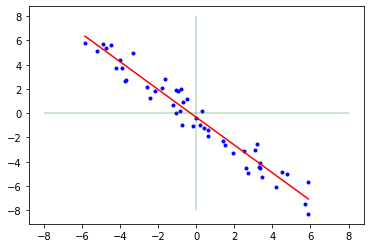

In [35]:
y_pred = linear_regression(x_lin_df, betas[0], betas[1])
plt.plot(x_lin_df, y_lin_df, 'b.')
plt.plot(x_lin_df, y_pred, 'r-')
plt.plot([0, 0], [-8, 8], 'g-', [-8, 8], [0, 0], 'g-', linewidth=0.4)

print("Mean Squared Error (MSE): {}".format(linear_regression_mse(y_lin_df, y_pred)))

## 4.2 - Gradient Descent for multiple linear regression

In [36]:
np.random.seed(42)

df = pd.read_csv('data/polynomial-learning-notebook.csv')
df = df.sort_values('x')
x_pln_df = df['x'].values
X_pln_df = df.drop(columns='y').values
y_pln_df = df['y'].values

betas = gradient_descent_multiple_linear_regression(
    X_pln_df, 
    y_pln_df, 
    np.random.rand(4), 
    0.001, 
    5000, 
    clip=True)

Now plot the solution:

Mean Squared Error (MSE): 14.943329615243453


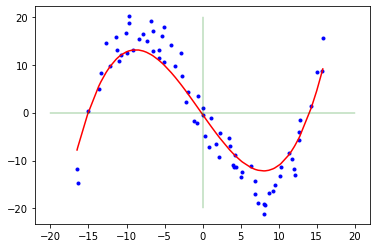

In [37]:
y_pred = multiple_linear_regression(X_pln_df, betas.flatten())
plt.plot(x_pln_df, y_pln_df, 'b.')
plt.plot(x_pln_df, y_pred, 'r-')
plt.plot([0, 0], [-20, 20], 'g-', [-20, 20], [0, 0], 'g-', linewidth=0.4)

print("Mean Squared Error (MSE): {}".format(linear_regression_mse(y_pln_df, y_pred)))

## 4.3 - Gradient Descent for multiple linear regression: diabetes example

Finally let's run Gradient Descent for the previous complex example:

In [38]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes

data = load_diabetes()

X_db = pd.DataFrame(data['data'], columns=data['feature_names'])
y_db = pd.Series(data['target'], name='medv')

pd.concat((X_db, y_db), axis=1).head(5)

betas = gradient_descent_multiple_linear_regression(
    X_db.values, 
    y_db.values, 
    np.random.rand(X_db.shape[1]+1), 
    0.1, 
    5000)


Print the coefficients and the intercept and compare them and the error with the previous methods:

In [39]:
betas = betas.flatten()
y_pred = multiple_linear_regression(X_db.values, betas)

print('Feature coefficients: ')
print(pd.Series(betas[1:], X_db.columns))
print('\n')

print('Intercept: {}'.format(betas[0]))
print('\n')

print('\nTargets for the first 5 rows: \n\n', y_db.head(5).values)
print('\nPredictions for the first 5 rows: \n\n', y_pred[:5])
print("Mean Squared Error (MSE): {}".format(linear_regression_mse(y_db.values, y_pred)))

Feature coefficients: 
age      6.477416
sex   -197.604938
bmi    487.727762
bp     302.664704
s1     -41.672774
s2    -106.719363
s3    -206.725952
s4     128.485965
s5     407.329775
s6     117.104678
dtype: float64


Intercept: 152.1334841628963



Targets for the first 5 rows: 

 [151.  75. 141. 206. 135.]

Predictions for the first 5 rows: 

 [199.31724465  71.17863611 172.67029998 160.45809677 127.52635757]
Mean Squared Error (MSE): 2899.0843162762653


And that is it! Congratulations, you've just learned your first predictive model! You've learned how to perform linear regressions with simple and multiple input models, and are now able to solve them through closed form solutions and even through a simple iterative methods. Now go on and apply what you've learned in the exercises. In the next units you will see other types of tasks and models and all sorts of other advanced topics.

![im-ready](assets/im-ready.gif)
